### Load dependancies

In [146]:
# wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# data
from datasets import load_dataset

# modelling
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, make_scorer, f1_score, roc_curve, auc

In [2]:
# settings for visuals
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", palette="pastel", rc=custom_params)

### Install dataset

In [3]:
dataset = load_dataset("mstz/speeddating")["train"]

In [116]:
# Convert Dataset to pandas DataFrame
df = dataset.to_pandas()

In [117]:
df.head() # preview data

,is_dater_male,dater_age,dated_age,age_difference,dater_race,dated_race,are_same_race,same_race_importance_for_dater,same_religion_importance_for_dater,attractiveness_importance_for_dated,...,interests_correlation,expected_satisfaction_of_dater,expected_number_of_likes_of_dater_from_20_people,expected_number_of_dates_for_dater,dater_liked_dated,probability_dated_wants_to_date,already_met_before,dater_wants_to_date,dated_wants_to_date,is_match
0,False,21,27,6,'Asian/Pacific Islander/Asian-American',caucasian,False,2.0,4.0,35.0,...,0.14,3.0,2,4,7.0,6.0,True,True,False,0
1,False,21,22,1,'Asian/Pacific Islander/Asian-American',caucasian,False,2.0,4.0,60.0,...,0.54,3.0,2,4,7.0,5.0,True,True,False,0
2,False,21,23,2,'Asian/Pacific Islander/Asian-American',caucasian,False,2.0,4.0,30.0,...,0.61,3.0,2,4,7.0,6.0,True,True,True,1
3,False,21,24,3,'Asian/Pacific Islander/Asian-American','Latino/Hispanic American',False,2.0,4.0,30.0,...,0.21,3.0,2,4,6.0,6.0,True,True,True,1
4,False,21,25,4,'Asian/Pacific Islander/Asian-American',caucasian,False,2.0,4.0,50.0,...,0.25,3.0,2,4,6.0,5.0,True,False,True,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048 entries, 0 to 1047
Data columns (total 65 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   is_dater_male                                     1048 non-null   bool   
 1   dater_age                                         1048 non-null   int8   
 2   dated_age                                         1048 non-null   int8   
 3   age_difference                                    1048 non-null   int8   
 4   dater_race                                        1048 non-null   object 
 5   dated_race                                        1048 non-null   object 
 6   are_same_race                                     1048 non-null   bool   
 7   same_race_importance_for_dater                    1048 non-null   float64
 8   same_religion_importance_for_dater                1048 non-null   float64
 9   attractiveness_impo

### Problem Definition: Exploratory Data Analysis for an Online Dating Website

### Business Problem:
The online dating website has collected a comprehensive dataset about users and their interactions on the platform. The primary business problem is to gain insights into user preferences, behaviors, and potential factors contributing to successful matches. By performing exploratory data analysis (EDA) on the provided dataset, we aim to uncover patterns, correlations, and trends that can inform strategic decisions to enhance user experience and increase match success rates.

### Key Questions to Address:

1. User Preferences and Importance of Traits: Understand the importance users place on various traits (attractiveness, sincerity, intelligence, humor, ambition, shared interests) for both daters and dated individuals. Are there specific traits that are prioritized by users more than others?

2. Attraction and Satisfaction: Examine self-reported attractiveness, sincerity, intelligence, humor, and ambition of daters. Investigate how these self-reported traits compare to the reported impressions from the dated individuals. Do users accurately perceive these traits in themselves and others?

3. Interests and Correlations: Analyze user interests, both common and specific. Calculate the correlation between different interests and see if shared interests play a significant role in potential matches.

4. Match Probability and Successful Matches: Explore the variables that influence the probability of a date wanting to date someone and the likelihood of a match occurring. What factors contribute to a higher likelihood of a successful match?

5. Demographics and Match Success: Investigate the influence of demographic factors such as gender, age, race, and religion on match success. Are there any significant trends or biases in the data?

### Expected Outcome:
The exploratory data analysis will provide actionable insights into user behaviors, preferences, and potential factors influencing successful matches. These insights will guide the online dating website in refining their matchmaking algorithms, improving user recommendations, and enhancing the overall user experience, ultimately leading to increased user satisfaction and higher match success rates.

### What traits are prioritized more than others?

#### Findings:
- Not suprising for a dating site the most prioritized trait is attractiveness
- Intelligence is a close second.
- Both same race and religion aren't valued as much.

#### Whats next:
The next question to ask is whether these prefrences are the same among men and women.

In [7]:
traits_columns = ["same_race_importance_for_dater", "same_religion_importance_for_dater","attractiveness_importance_for_dater",
                  "sincerity_importance_for_dater", "intelligence_importance_for_dater",
                  "humor_importance_for_dater", "ambition_importance_for_dater", "shared_interests_importance_for_dater"]

In [8]:
traits_df = df[traits_columns].copy()

# Rename columns for better visualization
traits_df.columns = ["Same Race", "Same Religion", "Attractiveness", "Sincerity", "Intelligence", "Humor", "Ambition", "Shared Interests"]

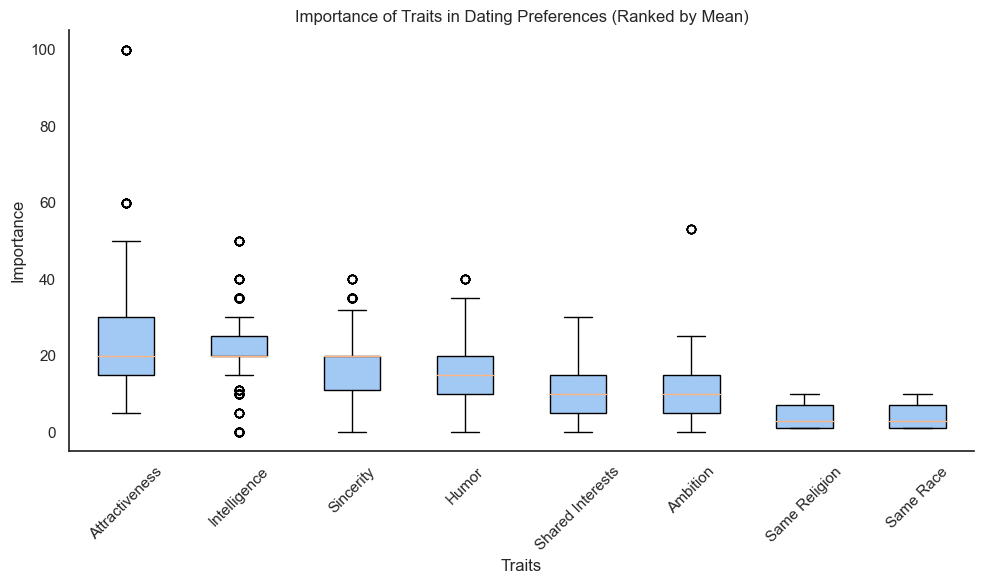

In [9]:
# Calculate mean values and sort the dataframe by mean
mean_values = traits_df.mean().sort_values(ascending=False)
sorted_traits_df = traits_df[mean_values.index]

# Create a vertical boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(sorted_traits_df.values, vert=True, patch_artist=True)
plt.xticks(range(1, len(sorted_traits_df.columns) + 1), sorted_traits_df.columns, rotation=45)
plt.title("Importance of Traits in Dating Preferences (Ranked by Mean)")
plt.ylabel("Importance")
plt.xlabel("Traits")
plt.tight_layout()

# Show the plot
plt.show()

#### Do men and women prioritize the same traits
##### Findings:
- Men value attractiveness more than women
- Women value intelligence more then men
- Ambition is valued more by women
- Most other traits are equally valued by both genders

In [10]:
women, men = df[~df['is_dater_male']], df[df['is_dater_male']] # seperate men and women

In [11]:
women_traits_df, men_traits_df = women[traits_columns].copy(), men[traits_columns].copy()

# Rename columns for better visualization
women_traits_df.columns = ["Same Race", "Same Religion", "Attractiveness", "Sincerity", "Intelligence", "Humor", "Ambition", "Shared Interests"]
men_traits_df.columns = ["Same Race", "Same Religion", "Attractiveness", "Sincerity", "Intelligence", "Humor", "Ambition", "Shared Interests"]

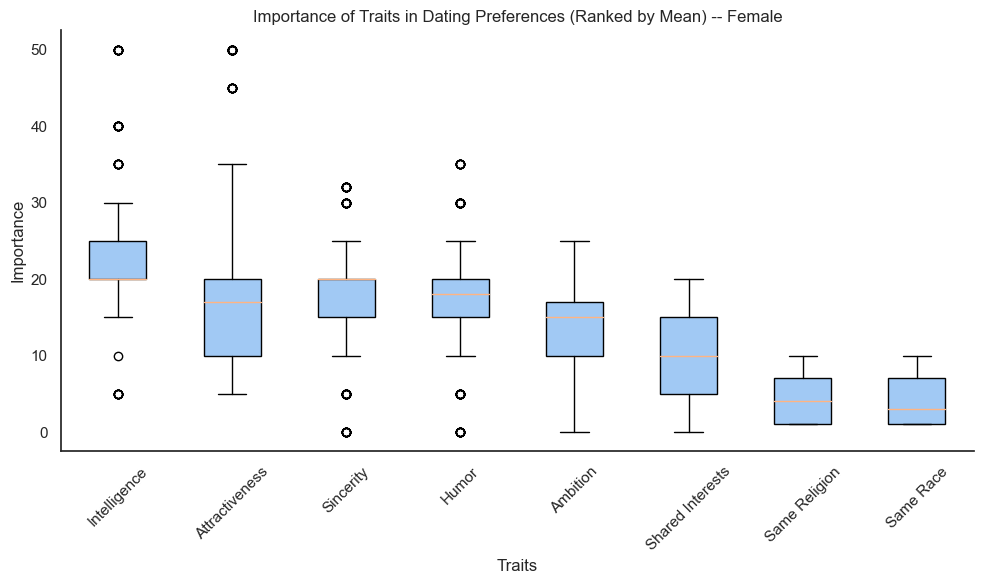

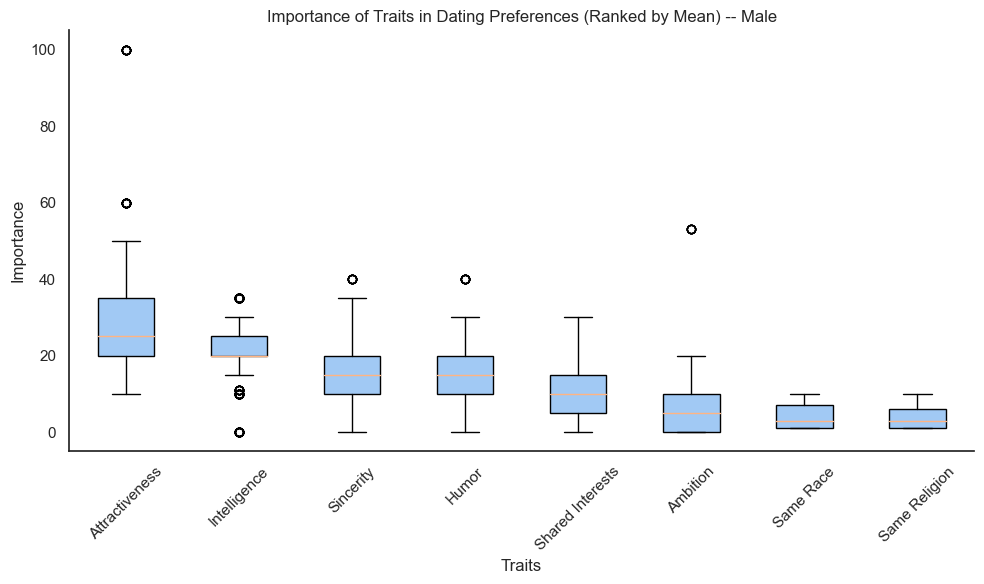

In [12]:
# distribution in women
# Calculate mean values and sort the dataframe by mean
women_mean_values = women_traits_df.mean().sort_values(ascending=False)
sorted_women_traits_df = women_traits_df[women_mean_values.index]

# Create a vertical boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(sorted_women_traits_df.values, vert=True, patch_artist=True)
plt.xticks(range(1, len(sorted_women_traits_df.columns) + 1), sorted_women_traits_df.columns, rotation=45)
plt.title("Importance of Traits in Dating Preferences (Ranked by Mean) -- Female")
plt.ylabel("Importance")
plt.xlabel("Traits")
plt.tight_layout()

# Show the plot
plt.show()


# distribution in men
# Calculate mean values and sort the dataframe by mean
men_mean_values = men_traits_df.mean().sort_values(ascending=False)
sorted_men_traits_df = men_traits_df[men_mean_values.index]

# Create a vertical boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(sorted_men_traits_df.values, vert=True, patch_artist=True)
plt.xticks(range(1, len(sorted_men_traits_df.columns) + 1), sorted_men_traits_df.columns, rotation=45)
plt.title("Importance of Traits in Dating Preferences (Ranked by Mean) -- Male")
plt.ylabel("Importance")
plt.xlabel("Traits")
plt.tight_layout()

# Show the plot
plt.show()

### Are users accurately perciving themselves
#### Findings:
- Every one percived themselves more favorable than other percived them
- Humor and Sincerity had the biggest difference in terms of what people thought about themselves and what others thought
- Ambition was the most similar in terms of perception from oneself and from others

In [13]:
self_perception = ["self_reported_attractiveness_of_dater", "self_reported_sincerity_of_dater",
                   "self_reported_intelligence_of_dater", "self_reported_humor_of_dater",
                   "self_reported_ambition_of_dater"]
others_perception = ["reported_attractiveness_of_dated_from_dater", "reported_sincerity_of_dated_from_dater",
                     "reported_intelligence_of_dated_from_dater", "reported_humor_of_dated_from_dater", 
                     "reported_ambition_of_dated_from_dater"]

# Interleave self_perception and others_perception
perceptions = [val for pair in zip(self_perception, others_perception) for val in pair]

print(perceptions)

['self_reported_attractiveness_of_dater', 'reported_attractiveness_of_dated_from_dater', 'self_reported_sincerity_of_dater', 'reported_sincerity_of_dated_from_dater', 'self_reported_intelligence_of_dater', 'reported_intelligence_of_dated_from_dater', 'self_reported_humor_of_dater', 'reported_humor_of_dated_from_dater', 'self_reported_ambition_of_dater', 'reported_ambition_of_dated_from_dater']


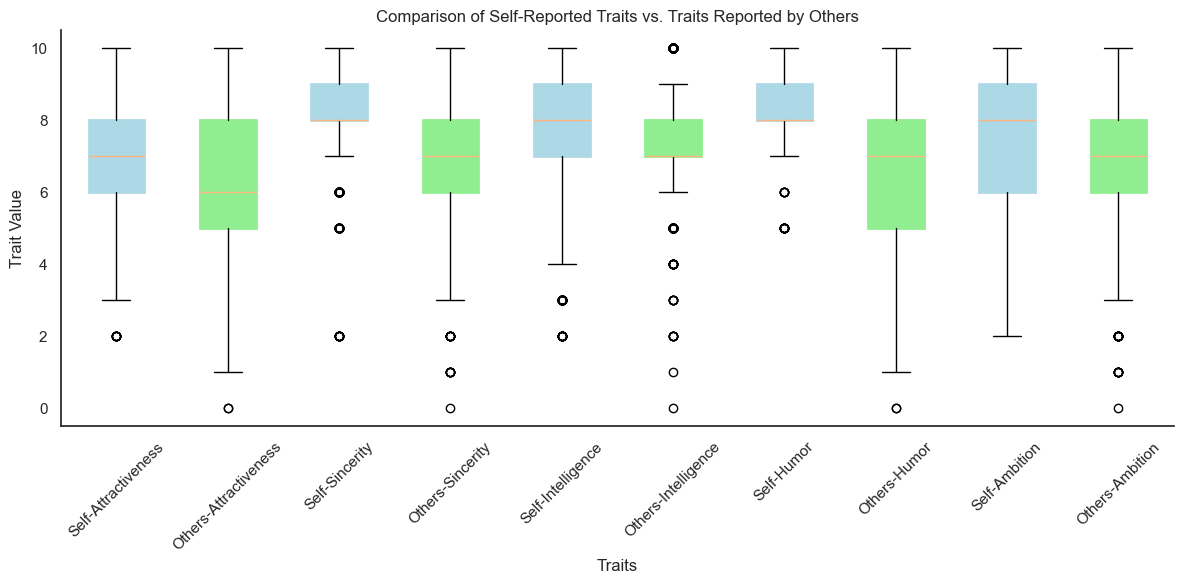

In [14]:
perception_df = df[perceptions]

# Rename columns for better visualization
perception_df.columns = ["Self-Attractiveness", "Others-Attractiveness", "Self-Sincerity", "Others-Sincerity",
                         "Self-Intelligence", "Others-Intelligence", "Self-Humor", "Others-Humor", "Self-Ambition","Others-Ambition"]

# Create a vertical boxplot
plt.figure(figsize=(12, 6))
bp = plt.boxplot(perception_df.values, vert=True, patch_artist=True)

# Set colors for self and other boxes
self_color = 'lightblue'
other_color = 'lightgreen'

for index, box in enumerate(bp['boxes']):
    if (index+1) % 2 == 0:
        box.set(color=other_color, linewidth=2)
        box.set(facecolor=other_color)
    else:
        box.set(color=self_color, linewidth=2)
        box.set(facecolor=self_color)


plt.xticks(range(1, len(perception_df.columns) + 1), perception_df.columns, rotation=45)
plt.title("Comparison of Self-Reported Traits vs. Traits Reported by Others")
plt.ylabel("Trait Value")
plt.xlabel("Traits")
plt.tight_layout()

# Show the plot
plt.show()

### Do users with a specific intrest expect their potential partner to have the same intrest.
We now that shared intrest isn't something either men or women prioritise, but in this section will try and look to find out if this is the same across all intrests, i.e.<br>
Do people who are intrested in tv expect their partner to be intrested to 

#### Findings:
- No one actually cares about shared intrests

In [15]:
intrests = ["dater_interest_in_sports", "dater_interest_in_tvsports", "dater_interest_in_exercise",
            "dater_interest_in_dining", "dater_interest_in_museums", "dater_interest_in_art", 
            "dater_interest_in_hiking", "dater_interest_in_gaming", "dater_interest_in_clubbing",
            "dater_interest_in_reading", "dater_interest_in_tv", "dater_interest_in_theater",
            "dater_interest_in_movies", "dater_interest_in_concerts", "dater_interest_in_music",
            "dater_interest_in_shopping", "dater_interest_in_yoga"]
shared_intest_importance = ["shared_interests_importance_for_dater"]

In [16]:
intrests_df = df[intrests + shared_intest_importance]

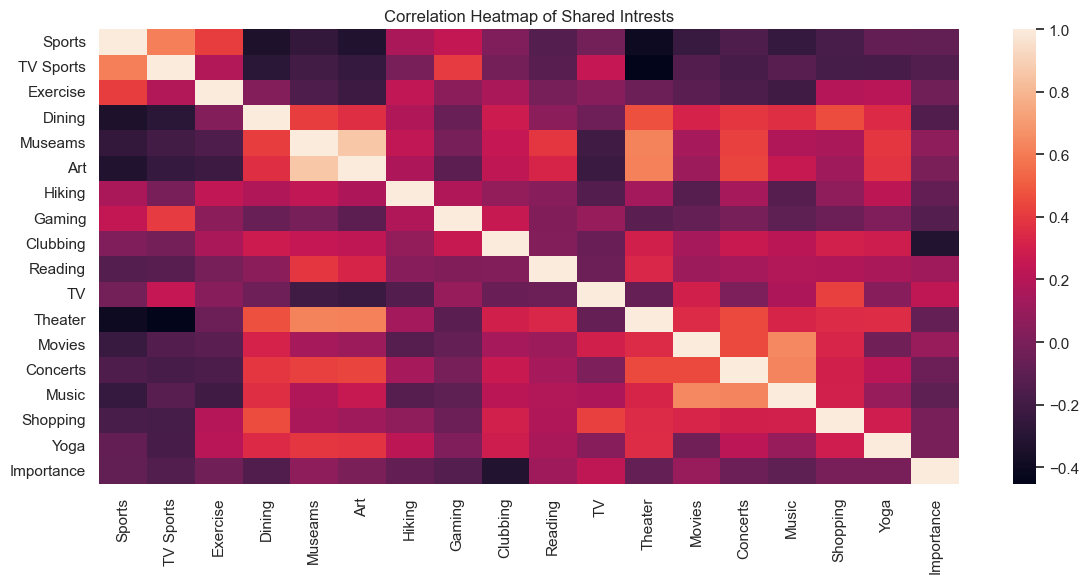

In [17]:
# Rename columns for better visulizations
intrests_df.columns = ["Sports", "TV Sports", "Exercise", "Dining", "Museams", "Art", "Hiking",
                       "Gaming", "Clubbing", "Reading", "TV", "Theater", "Movies", "Concerts",
                       "Music", "Shopping", "Yoga", "Importance"]

# Create a correlation heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(intrests_df.corr())

# plt.xticks(range(1, len(perception_df.columns) + 1), perception_df.columns, rotation=45)
plt.title("Correlation Heatmap of Shared Intrests")
plt.tight_layout()

# Show the plot
plt.show()

### What factors contribute to a higher likelihood of a successfull match
#### Finding:
- Although initial analysis indicated that shared intrests aren't taen into consideration, it seems to be a good indicater of a match
- As we expected where the person your trying to match with finds you attractive will infuence your chances of success.

In [153]:
target = 'is_match' # traget variable
leakers = ['dater_wants_to_date', 'dated_wants_to_date'] # columns that would cause data leakage
# split features and target
X = df.drop(columns=[target]+leakers)
y =  df[target]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Baseline model

In [155]:
# Create a baseline classifier that always predicts 0
baseline_clf = DummyClassifier(strategy="constant", constant=0)

# Fit the baseline classifier on the training data
baseline_clf.fit(X_train, y_train)

# Predict on the test data
y_pred = baseline_clf.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred)

print("Baseline Classifier Classification Report:\n", report)

Baseline Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90       173
           1       0.00      0.00      0.00        37

    accuracy                           0.82       210
   macro avg       0.41      0.50      0.45       210
weighted avg       0.68      0.82      0.74       210



c:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### RF Classifier #1

In [156]:
# determine numerical features
numerical_ix = X.select_dtypes(include=['int32', 'float64']).columns

# determine boolean features 
boolean_ix = X.select_dtypes(include=['bool']).columns

# determine categorical features
categorical_ix = X.select_dtypes(include=['object']).columns

# define preprocessign transformer
t = [('num', StandardScaler(), numerical_ix),
     ('cat', OneHotEncoder(use_cat_names=True), categorical_ix)]

preprocess = ColumnTransformer(transformers=t, remainder='passthrough')

# define model
classifer = RandomForestClassifier(random_state=42)

# create pipeline
pipeline = Pipeline(steps=[('preprocess', preprocess), ('classifer', classifer)])

# Fit pipeline
pipeline.fit(X_train, y_train)

# predict on the test data
y_pred = pipeline.predict(X_test)

# Generate classification report
report = classification_report(y_test, y_pred)

print("RF Classifier Classification Report:\n", report)

RF Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91       173
           1       0.67      0.22      0.33        37

    accuracy                           0.84       210
   macro avg       0.76      0.60      0.62       210
weighted avg       0.82      0.84      0.81       210



#### Plot ROC AUC

Function used in this section

In [91]:
def plot_roc_auc(models, model_names, test_data):
    """
    Plots ROC-AUC curves for multiple models.
    
    Parameters:
    - models: List of model instances
    - model_names: List of model names correspondig to models.
    - test_data: A tuple containing (X_test, y_test).
    
    Returns:
    None (Displays the ROC-AUC plot)
    """
    plt.figure(figsize=(8, 6))
    X_test, y_test = test_data
    
    for model, name in zip(models, model_names):
        y_pred_prob = model.predict_proba(X_test)
        
        fpr = {}
        tpr = {}
        roc_auc = {}
        
        for i in range(len(model.classes_)):
            fpr[i], tpr[i], _ = roc_curve(
                y_test == model.classes_[i], y_pred_prob[:, i]
            )
            roc_auc[i] = auc(fpr[i], tpr[i])
            
        for i in range(len(model.classes_)):
            plt.plot(
                fpr[i],
                tpr[i],
                lw=2,
                label=f"{name} - Class {model.classes_[i]} (AUC = {roc_auc[i]:.2f})",
            )

    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-AUC Curves for Multiclass Classification")
    plt.legend(loc="lower right")
    plt.show()

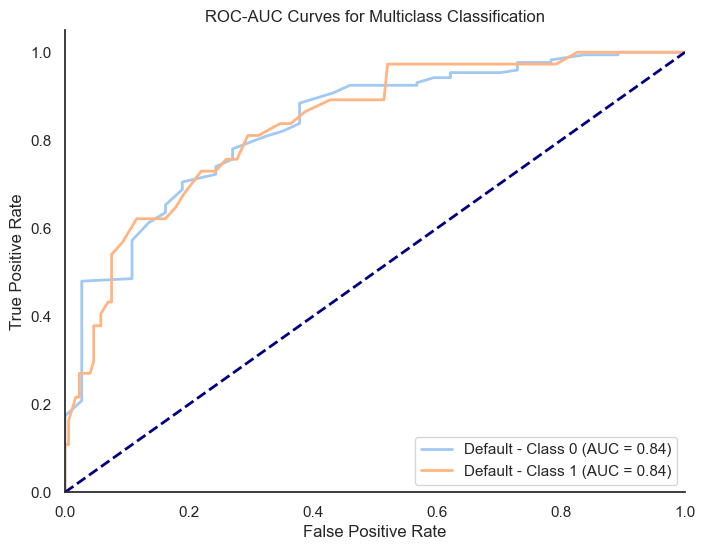

In [157]:
models = [pipeline] # models
model_names = ["Default"] # respective model names

# Plot ROC_AUC curves for 3 models
plot_roc_auc(models, model_names, (X_test, y_test))

#### Feature importance

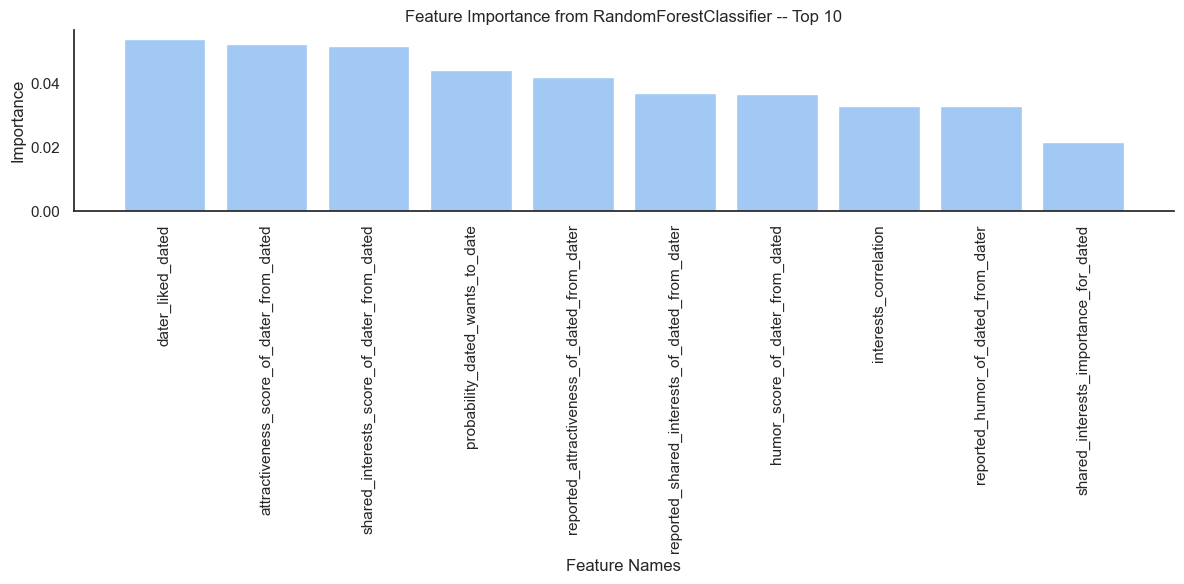

In [158]:
# get preprocessor
preprocessor = pipeline.named_steps["preprocess"]

# get RF classifer
best_classifier = pipeline.named_steps['classifer']

# Get feature importances
feature_importances = best_classifier.feature_importances_

# Get the list of selected feature names after preprocessing
selected_feature_names = []
for name, transformer, features in preprocessor.transformers_:
    if transformer == "passthrough":
        selected_feature_names.extend(features)
    else:
        if isinstance(transformer, OneHotEncoder):
            feature_names = transformer.get_feature_names_out(input_features=features)
        else:
            feature_names = features

        selected_feature_names.extend(feature_names)

# Cip the features and their importance
features_importance = list(zip(selected_feature_names, feature_importances))

# Sort the zipped list based on feature importance
features_importance.sort(key=lambda x: x[1], reverse=True)

# Unzip the sorted list into separate lists
sorted_selected_feature_names, sorted_feature_importances = zip(*features_importance[:10]) # top 10 

# Plot the bar graph
plt.figure(figsize=(12, 6))
plt.bar(
    range(len(sorted_selected_feature_names)),
    sorted_feature_importances,
    align="center",
)
plt.xticks(
    range(len(sorted_selected_feature_names)),
    sorted_selected_feature_names,
    rotation=90,
)
plt.xlabel("Feature Names")
plt.ylabel("Importance")
plt.title("Feature Importance from RandomForestClassifier -- Top 10")
plt.tight_layout()
plt.show()